# **PROBLEM STATEMENT**

## **Business Problem**

**What is Mercari?**

Mercari is Japan’s biggest community-powered marketplace. It is like an ebay or OLX in India. Sellers come to this online market-place to sell vast variety of products in various conditions from new to poor.

**Problem Statement**

It can be hard to know how much something’s really worth.<br>
There are a lot of factors that play a vital role in determining the price of a product like brand name, condition of the item, category of the item, specifications of the item, etc. Even a subtle difference in any of the factors can make a huge difference in the price of the product.<br>
For example consider the following two items,<br>
<ul>
<li>Running shoes manufactured by Adidas, soft sole</li>
<li>Running shoes manufactured in local factory, a bit used, soft sole</li>
</ul>
The former one will most likely cost more than the latter.<br>
However, the seller might be confused as to what should be the optimal selling price of the product, such that the price is in accordance with the price at which such prodcut is sold in the market. Such a price will make the buyers willing to buy it and the seller's profit will also not be hurt.

**Business objectives and constraints**

<ul>
<li>The goal is to solve the problem of suggesting the appropriate price of products to online sellers</li>
<li>No latency constraints. Because we would like to suggest a higly accurate price to the seller, even if it takes a reasonable amount of time</li>
</ul>

## **Machine Learning Probelm**

**Data Overview**

The data was uploaded by Mercari on Kaggle, https://www.kaggle.com/c/mercari-price-suggestion-challenge/
<br>
<p>The training file (.tsv) consist of a list of product listings which is tab-delimited.</p>
<ul>
<li>train_id - the id of the listing</li>
<li>name - the title of the listing</li>
<li>item_condition_id - the condition of the items provided by the seller. From 1 to 5. 1 being new and 5 being poor</li>
<li>category_name - category of the listing</li>
<li>brand_name</li>
<li>price - the price that the item was sold for. This is the target variable that we will predict. The unit is USD.
<li>shipping - 1 if shipping fee is paid by seller and 0 by buyer</li>
<li>item_description - the full description of the item.</li>
</ul>
The size of the train.tsv = 322 MB. <br>
Totla number of product listings = 14,82,535

**Type of Machine Learning problem**

<ul>
<li>The prices are in real number. Hence, this problem falls under a regression problem
</li>
</ul>

**Performance Metric**

The metric that we will use is Root Mean Squared Logarithmic Error (RMSLE). The choice of this metric is due to the following reasons,
<ul>
<li>It is robust to outliers</li>
<li>It is scale invariant</li>
<li>It will penalize under-estimation more, than over-estimation. This makes sense from the business perspective, because ideally the company would like to sell the products at a reasonably higher price. This also increases the customer (seller) satisfaction as well as the commission that the company might get for each sale. Another reason is that, the price distribution is highly skewed to the right. Meaning there are a lot of low priced products as compared to very high priced products.
</li>
</ul>

**Train and Test Dataset**

We build train and test by randomly splitting in the ratio of 80:20 as we have sufficient points to work with.

# **DATA INITIZLIZATION**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
if 'train.tsv' not in os.listdir(): 
    !kaggle competitions download -c mercari-price-suggestion-challenge
    get_ipython().system_raw("7z x \*.7z && rm *.7z")
    get_ipython().system_raw("7z x \*.zip && rm *.zip")

 64% 5.00M/7.77M [00:00<00:00, 44.5MB/s]
100% 7.77M/7.77M [00:00<00:00, 49.9MB/s]
 87% 65.0M/74.3M [00:01<00:00, 21.7MB/s]
100% 74.3M/74.3M [00:01<00:00, 51.3MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 114MB/s]
 96% 283M/294M [00:05<00:00, 67.0MB/s]
100% 294M/294M [00:05<00:00, 59.2MB/s]
 74% 25.0M/34.0M [00:00<00:00, 28.1MB/s]
100% 34.0M/34.0M [00:00<00:00, 85.8MB/s]


In [ ]:
import pandas as pd

train_df = pd.read_csv('train.tsv', sep='\t')

# Price range should be $5-$2000, https://www.mercari.com/us/help_center/article/69
train_df = train_df[train_df['price']>=5]  # Removing the prodicts with prices less than 5
train_df = train_df[train_df['price']<=2000]  # Removing the prodicts with prices more than 2000
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# **EDA**

In [ ]:
print(train_df.shape)
print(train_df.columns)

(1482535, 8)
Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')


**Checking number of null values**

In [ ]:
train_df.isnull().sum(axis=0)

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [ ]:
total_rows = train_df.shape[0]
null_values = train_df.isnull().sum(axis=0)
print("Null brands", round(null_values['brand_name']/total_rows*100,2),'%')
print("Null categories", round(null_values['category_name']/total_rows*100,2),'%')
print("Null item description", round(null_values['item_description']/total_rows*100,4),'%')

Null brands 42.68 %
Null categories 0.43 %
Null item description 0.0003 %


**Analyzing Price**

In [ ]:
train_df['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

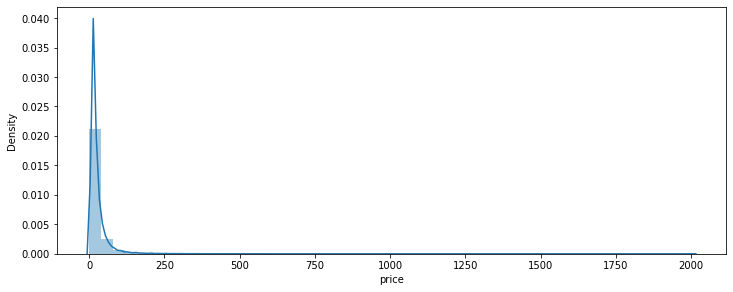

In [ ]:
# Plot the distribution of the prices
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['price'])

We can see that the price distribution is highly skewed. From the above graph we can see that most of the prices are between 0 to 250. There are very few items which are priced above 250. <br>
We will get more clear picture of the price distribution, when we check the prices at several percentiles.

In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,101,10):
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

0 th percentile is 0.0
10 th percentile is 7.0
20 th percentile is 10.0
30 th percentile is 12.0
40 th percentile is 14.0
50 th percentile is 17.0
60 th percentile is 20.0
70 th percentile is 26.0
80 th percentile is 34.0
90 th percentile is 51.0
100 th percentile is 2009.0


In [ ]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101):
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

90 th percentile is 51.0
91 th percentile is 55.0
92 th percentile is 58.0
93 th percentile is 62.0
94 th percentile is 67.0
95 th percentile is 75.0
96 th percentile is 85.0
97 th percentile is 99.0
98 th percentile is 122.0
99 th percentile is 170.0
100 th percentile is 2009.0


In [ ]:
# printing 99 to 100 percentile values with step size of 0.1
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

99.1 th percentile is 180.0
99.2 th percentile is 189.0
99.3 th percentile is 200.0
99.4 th percentile is 210.0
99.5 th percentile is 230.3300000000745
99.6 th percentile is 256.0
99.7 th percentile is 286.0
99.8 th percentile is 340.0
99.9 th percentile is 450.0
100 th percentile is 2009.0


In [ ]:
print("Number of products with price >170 =",len(train_df[train_df['price']>170]['price']))

Number of products with price >170 = 14741


From the prices at the above percentiles, we can see that 99% of the prices are less that 170. The higher prices are outliers but they are not anomolies. Now, there are two things that can be done. <br> 
1). We discard the outliers and our model never learns to predict higher prices.<br>
2). We do not discard the outliers and keep them in our training dataset, and our model learns the higher priced products too. BUT... this would hurt the overall model performance, because after all we are considering outliers in our training.<br>
My suggestion would be to take option 2. We can keep the higher priced products, but as most of the products are lower priced, we can use some kind of metric that would help the model learn the lower priced products more than the overpriced ones, but not totally discarding the higher priced products. <br>
Here our metric RMSLE comes to the rescue. This metric is typically used when the data is highly skewed (especially to the right, like in our case). This is because of its <i>log</i> operation, and its resultant mathematical properties like sacle invariance and robustness to outliers, to name a few.

**Applying log transform on the price**

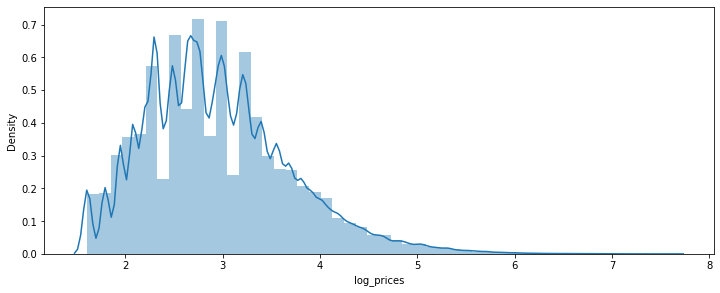

In [ ]:
from scipy import stats

train_df['log_prices']= np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_prices'])

**Analyzing Shipping**

Shipping 0 = 55.27 %
Shipping 1 = 44.73 %


Text(0, 0.5, 'Number of products')

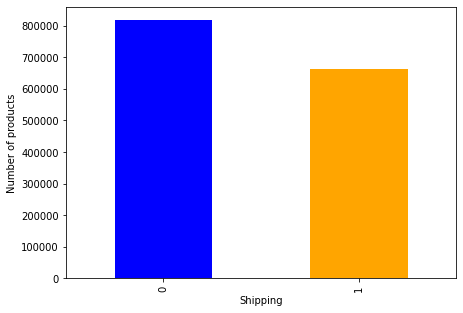

In [ ]:
total_rows = train_df.shape[0]
shipping_counts = train_df['shipping'].value_counts()
print("Shipping 0 =", round(shipping_counts[0]/total_rows*100,2),'%')
print("Shipping 1 =", round(shipping_counts[1]/total_rows*100,2),'%')
ax = train_df['shipping'].value_counts().plot.bar(color=['blue','orange'], figsize=(7,5))
ax.set_xlabel("Shipping")
ax.set_ylabel("Number of products")

No big variation is observed in the number of items sold with seller shipping (1) or buyer shipping (0). However, the number of items where the seller pays the shipping is less than those where the buyer pays for it.

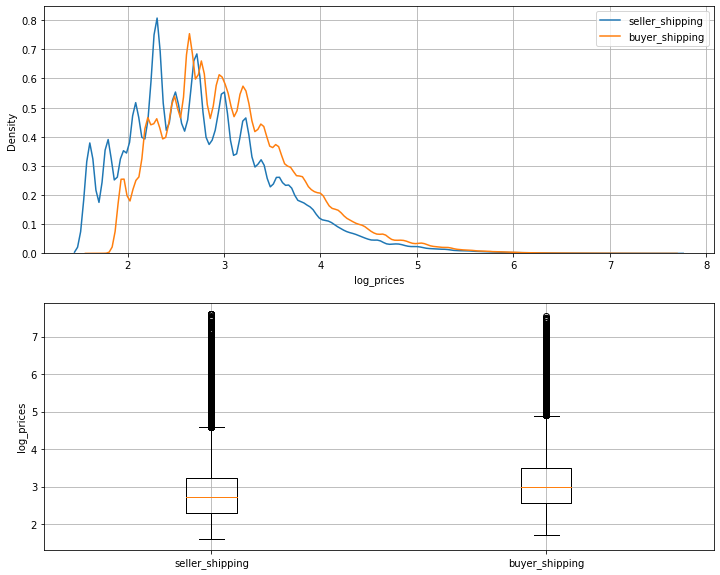

In [ ]:
seller_shipping = train_df[train_df['shipping']==1]['log_prices']
#seller_shipping = seller_shipping[seller_shipping<150]
buyer_shipping = train_df[train_df['shipping']==0]['log_prices']
#buyer_shipping = buyer_shipping[buyer_shipping<150]
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(seller_shipping, hist=False, label="seller_shipping")
ax = sns.distplot(buyer_shipping, hist=False, label="buyer_shipping")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

plt.subplot(212)
plt.boxplot([seller_shipping, buyer_shipping])
plt.xticks([1,2],('seller_shipping','buyer_shipping'))
plt.ylabel('log_prices')
plt.grid()
plt.show()

From the distribution of prices as per the shipping, we can see that, if the price of the product is very low (less than 6 dollars), then the shipping is mostly paid by the seller.<br>
antilog(~1.8 dollars) = 6 dollars

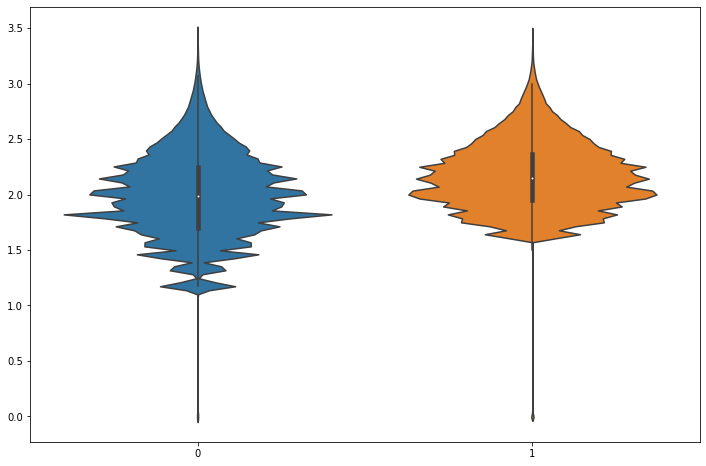

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(data=[seller_shipping, buyer_shipping])

**Analyzing Item Condition**

Condition 1 = 43.21 %
Condition 2 = 25.33 %
Condition 3 = 29.15 %
Condition 4 = 2.16 %
Condition 5 = 0.16 %


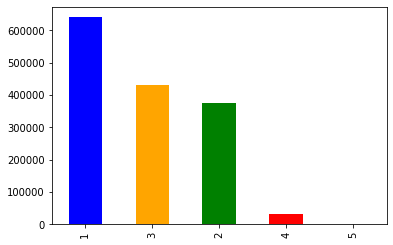

In [ ]:
total_rows = train_df.shape[0]
categories_counts = train_df['item_condition_id'].value_counts()
print("Condition 1 =", round(categories_counts[1]/total_rows*100,2),'%')
print("Condition 2 =", round(categories_counts[2]/total_rows*100,2),'%')
print("Condition 3 =", round(categories_counts[3]/total_rows*100,2),'%')
print("Condition 4 =", round(categories_counts[4]/total_rows*100,2),'%')
print("Condition 5 =", round(categories_counts[5]/total_rows*100,2),'%')

train_df['item_condition_id'].value_counts().plot.bar(color=['blue','orange','green','red','pink'])

There is a significant imbalance in the item condition categories, especially in category 4 and 5.

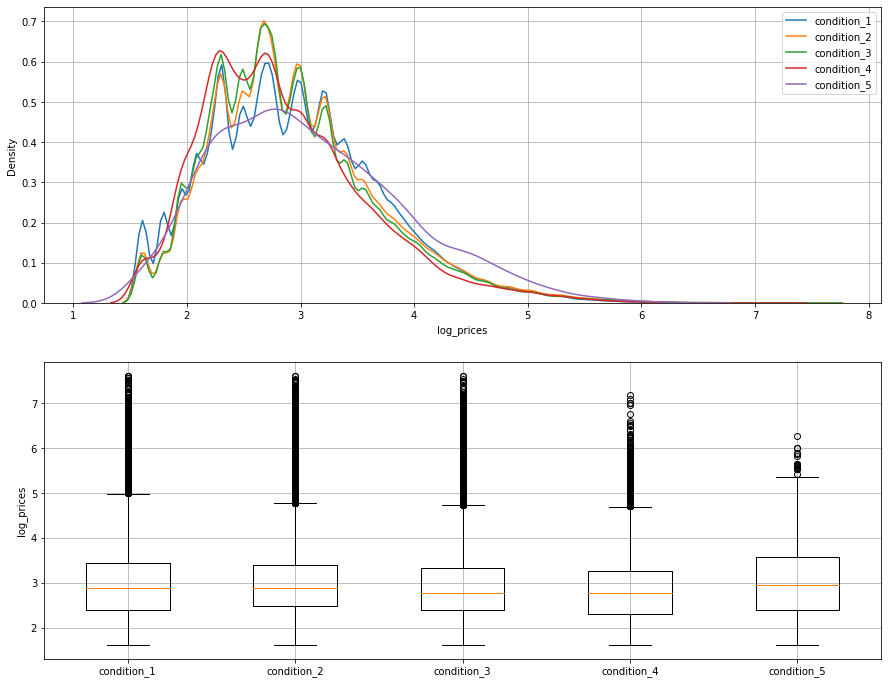

In [ ]:
condition_1 = train_df[train_df['item_condition_id']==1]['log_prices']
#condition_1 = condition_1[condition_1<150]

condition_2 = train_df[train_df['item_condition_id']==2]['log_prices']
#condition_2 = condition_2[condition_2<150]

condition_3 = train_df[train_df['item_condition_id']==3]['log_prices']
#condition_3 = condition_3[condition_3<150]

condition_4 = train_df[train_df['item_condition_id']==4]['log_prices']
#condition_4 = condition_4[condition_4<150]

condition_5 = train_df[train_df['item_condition_id']==5]['log_prices']
#condition_5 = condition_5[condition_5<150]

plt.figure(figsize=(15,12))
plt.subplot(211)
ax = sns.distplot(condition_1, hist=False, label="condition_1")
ax = sns.distplot(condition_2, hist=False, label="condition_2")
ax = sns.distplot(condition_3, hist=False, label="condition_3")
ax = sns.distplot(condition_4, hist=False, label="condition_4")
ax = sns.distplot(condition_5, hist=False, label="condition_5")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

plt.subplot(212)
plt.boxplot([condition_1, condition_2, condition_3, condition_4, condition_5])
plt.xticks([1,2,3,4,5],('condition_1', 'condition_2', 'condition_3', 'condition_4', 'condition_5'))
plt.ylabel('log_prices')
plt.grid()
plt.show()

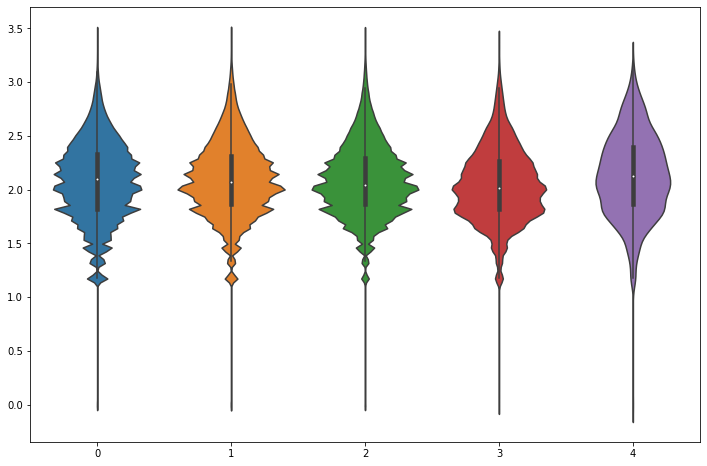

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(data=[condition_1, condition_2, condition_3, condition_4, condition_5])

We can say that the prices are evenly spreaded for each of the item condition category. This overlap can make the model indecisive. As a result this feature can be considered for some feature engineering hack.

**Analyzing Item Name**

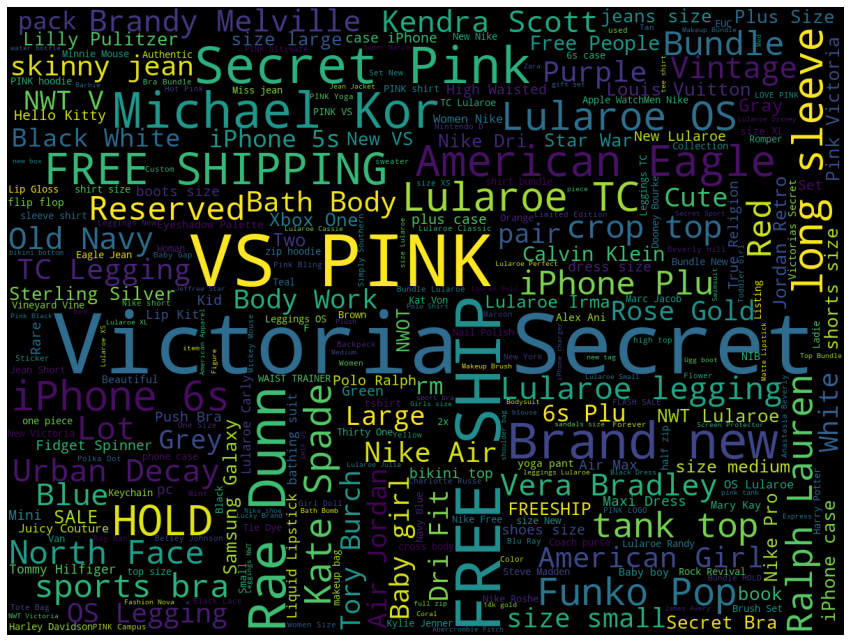

In [ ]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train_df['name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

We can see that most of the OP (original poster) are mentioning the brand names  and the name of product in the item name section. We can see that they are also highlighting the free shipping info in this section, in order to attract the buyers. As seen earlier, there are a lot of missing values in the brand name column. So, we can try some feature engineering hack to guess the missing brand name from the item name.

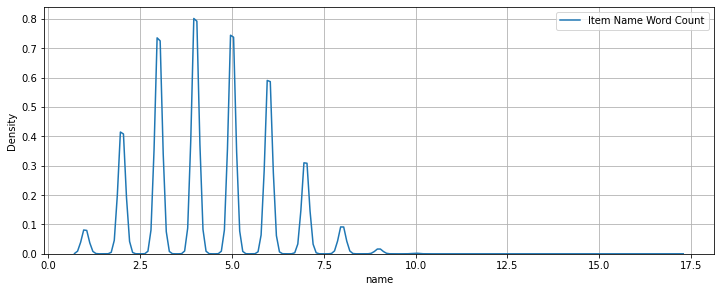

In [ ]:
# Analyse word count in description
word_counts = train_df['name'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(word_counts, hist=False, label="Item Name Word Count")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()
plt.show()

We can see that most of the products have their name section filled with the word count within the range of ~2 to 7 words. 

**Analyzing Item Description**

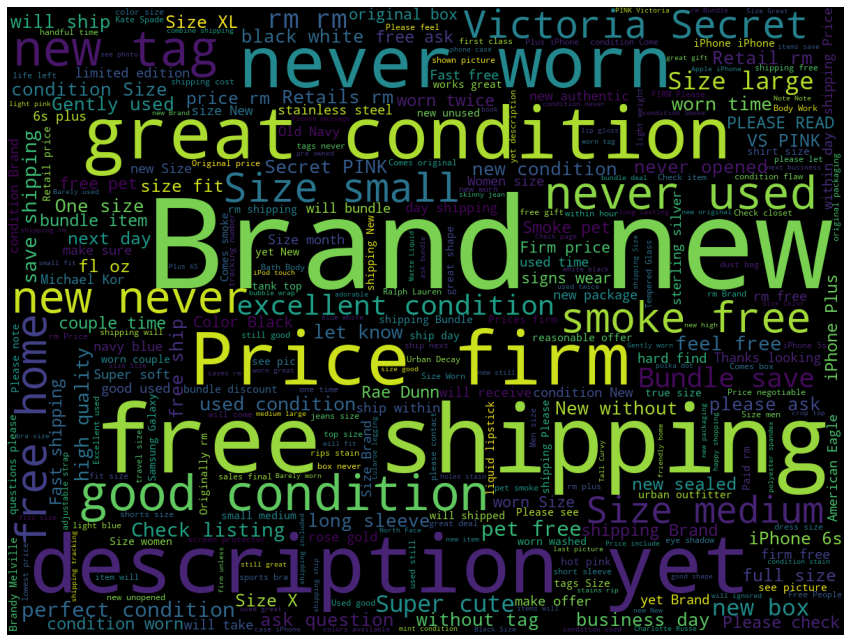

In [ ]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train_df['item_description'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

We can see that most of the OP (original poster) are using the words which describes the condition of the product like 'brand new', 'good condition', 'worn out'etc. We can use this info to do sentiment analysis on it, and add the sentiment scores as one of the features in the dataset. We can see that they are highlighting the shipping details in the description like 'free shipping'. They are also mentioning the brand names in the description. 

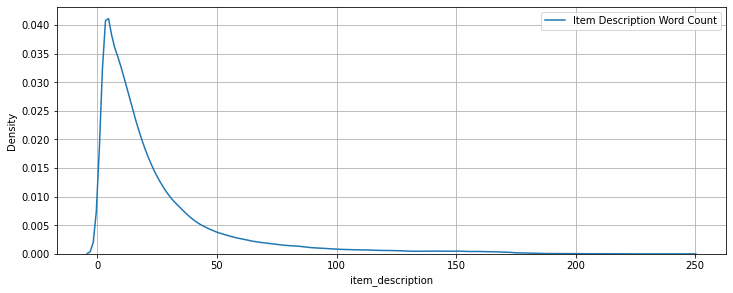

In [ ]:
# Analyse word count in description
word_counts = train_df['item_description'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(word_counts, hist=False, label="Item Description Word Count")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()
plt.show()

We can see that most of the products have their description section filled with the word count within the range of ~1 to 50 words. <br>
It is no surprise to see this distribution similar to log-normal distribution. So, we can use the standardized word length of the descriptions as one of our features.

**Analysing Brand Name**

In [ ]:
print("Number of unique brand names=",len(list(train_df['brand_name'].unique())))

Number of unique brand names= 4810


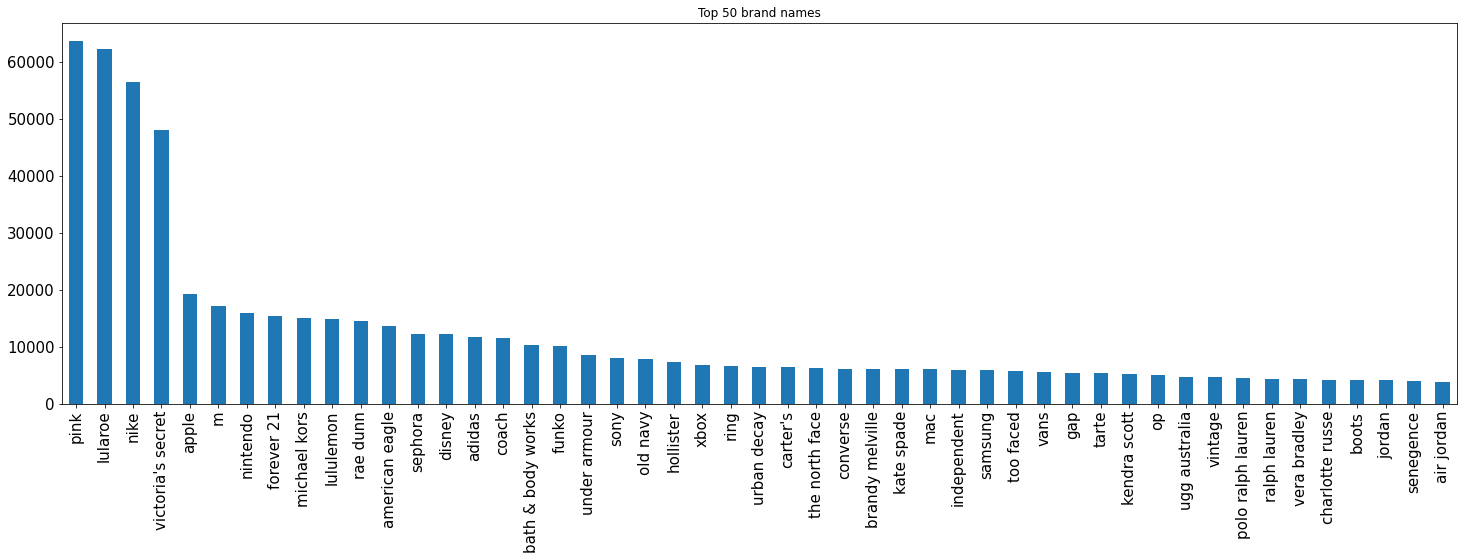

In [ ]:
train_df['brand_name'].value_counts()[1:50].plot(kind='bar', figsize=(25,7), title="Top 50 brand names", fontsize=15)

There are 4810 unique brand names. We can see that in the top 50 most mentioned brands, most of them are apperels and some are electronics.

**Analysing Categories**

In [ ]:
def split_cat(text):
    """
    This function separated the categories into its three parts. Main category, sub-category 1 and sub-category 2
    """
    try: 
        return text.split("/")
    except: 
        return ("No Label", "No Label", "No Label")

train_df['general_cat'], train_df['subcat_1'], train_df['subcat_2'] = zip(*train_df['category_name'].apply(lambda x: split_cat(x)))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.302585,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces


In [ ]:
print("No of unique values in main category: ",train_df['general_cat'].nunique())
print("No of unique values in Sub_category1: ",train_df['subcat_1'].nunique())
print("No of unique values in Sub_category2: ",train_df['subcat_2'].nunique())

No of unique values in main category:  11
No of unique values in Sub_category1:  114
No of unique values in Sub_category2:  871


In [ ]:
train_df['general_cat'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No Label                    6327
Name: general_cat, dtype: int64

In [ ]:
total_rows = train_df.shape[0]
general_cat_counts = train_df['general_cat'].value_counts()
print("Women=\t", round(general_cat_counts['Women']/total_rows*100,2),'%')
print("Beauty\t", round(general_cat_counts['Beauty']/total_rows*100,2),'%')
print("Kids=\t", round(general_cat_counts['Kids']/total_rows*100,4),'%')
print("Electronics=\t", round(general_cat_counts['Electronics']/total_rows*100,4),'%')
print("Men=\t", round(general_cat_counts['Men']/total_rows*100,4),'%')
print("Home=\t", round(general_cat_counts['Home']/total_rows*100,4),'%')
print("Vintage & Collectibles=\t", round(general_cat_counts['Vintage & Collectibles']/total_rows*100,4),'%')
print("Other=\t", round(general_cat_counts['Other']/total_rows*100,4),'%')
print("Handmade=", round(general_cat_counts['Handmade']/total_rows*100,4),'%')
print("Sports & Outdoors=\t", round(general_cat_counts['Sports & Outdoors']/total_rows*100,4),'%')
print("No Label=", round(general_cat_counts['No Label']/total_rows*100,4),'%')

Women=	 44.81 %
Beauty	 14.02 %
Kids=	 11.5808 %
Electronics=	 8.2757 %
Men=	 6.3189 %
Home=	 4.578 %
Vintage & Collectibles=	 3.1385 %
Other=	 3.059 %
Handmade= 2.0804 %
Sports & Outdoors=	 1.7094 %
No Label= 0.4268 %


In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["General Category", "Percentage"]

pt.add_row(['Women','44.81 %'])
pt.add_row(['Beauty','14.02 %'])
pt.add_row(['Kids','11.5808 %'])
pt.add_row(['Electronics','8.2757 %'])
pt.add_row(['Men','6.3189 %'])
pt.add_row(['Home','4.578 %'])
pt.add_row(['Vintage & Collectibles','3.1385 %'])
pt.add_row(['Other','3.059 %'])
pt.add_row(['Handmade','2.0804 %'])
pt.add_row(['Sports & Outdoors','1.7094 %'])
pt.add_row(['No Label','0.4268 %'])

print(pt)

+------------------------+------------+
|    General Category    | Percentage |
+------------------------+------------+
|         Women          |  44.81 %   |
|         Beauty         |  14.02 %   |
|          Kids          | 11.5808 %  |
|      Electronics       |  8.2757 %  |
|          Men           |  6.3189 %  |
|          Home          |  4.578 %   |
| Vintage & Collectibles |  3.1385 %  |
|         Other          |  3.059 %   |
|        Handmade        |  2.0804 %  |
|   Sports & Outdoors    |  1.7094 %  |
|        No Label        |  0.4268 %  |
+------------------------+------------+


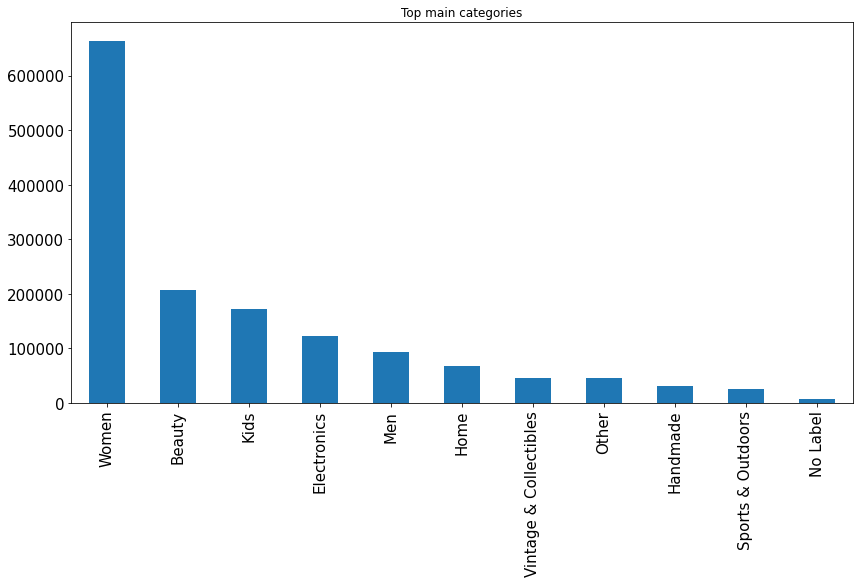

In [ ]:
train_df['general_cat'].value_counts().plot(kind='bar', figsize=(14,7), title="Top main categories", fontsize=15)

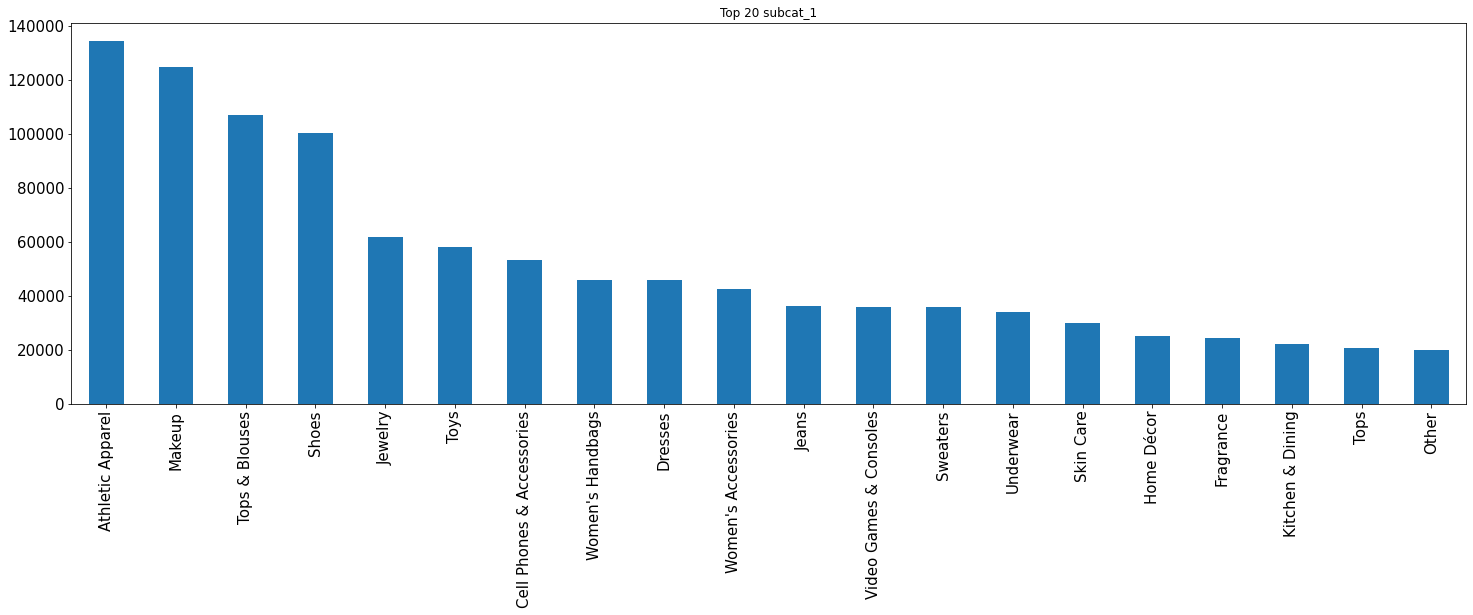

In [ ]:
train_df['subcat_1'].value_counts()[:20].plot(kind='bar', figsize=(25,7), title="Top 20 subcat_1", fontsize=15)

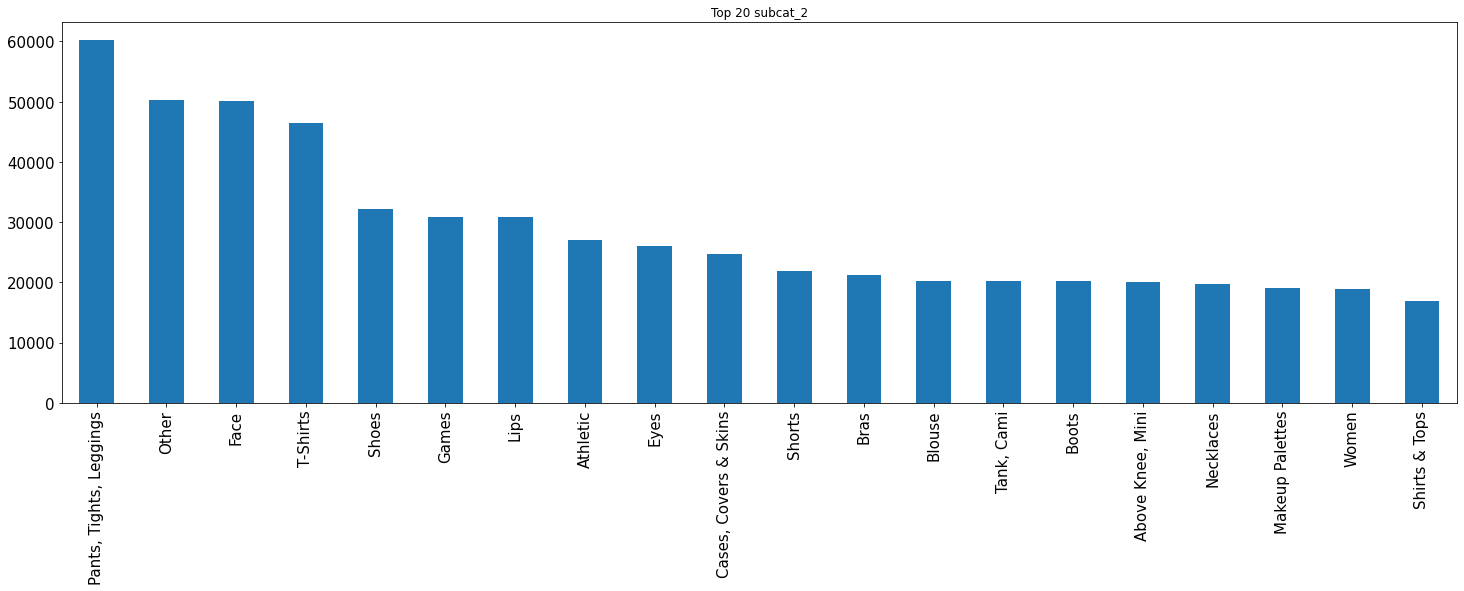

In [ ]:
train_df['subcat_2'].value_counts()[:20].plot(kind='bar', figsize=(25,7), title="Top 20 subcat_2", fontsize=15)

As suspected earlier from the brand names, most of the products are seen to belong to the apparels category that too for women. Only ~6000 categories are missing ('No Label' data). As the number of missing categories is very less, I don't think doing some feature engineering to fill them with some 'guessed' category is worth it. We can keep it as No Labeled data and see how our model is performing.

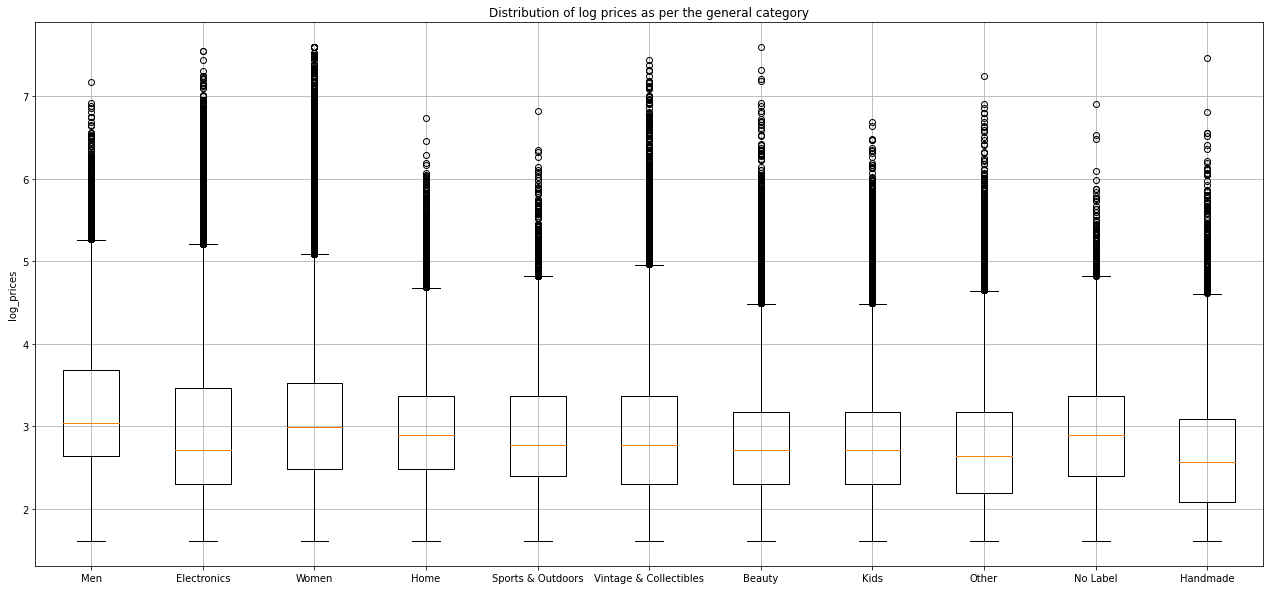

In [ ]:
plt.figure(figsize=(22,10))
gen_cat = [train_df.loc[train_df['general_cat']==cat, 'log_prices'] for cat in train_df['general_cat'].unique()]
plt.boxplot(gen_cat)
plt.xticks(np.arange(1,12), [cat for cat in train_df['general_cat'].unique()])
plt.ylabel('log_prices')
plt.title('Distribution of log prices as per the general category')
plt.grid()
plt.show()

[Text(0, 0, 'Men'),
 Text(0, 0, 'Electronics'),
 Text(0, 0, 'Women'),
 Text(0, 0, 'Home'),
 Text(0, 0, 'Sports & Outdoors'),
 Text(0, 0, 'Vintage & Collectibles'),
 Text(0, 0, 'Beauty'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Kids'),
 Text(0, 0, 'No Label'),
 Text(0, 0, 'Handmade')]

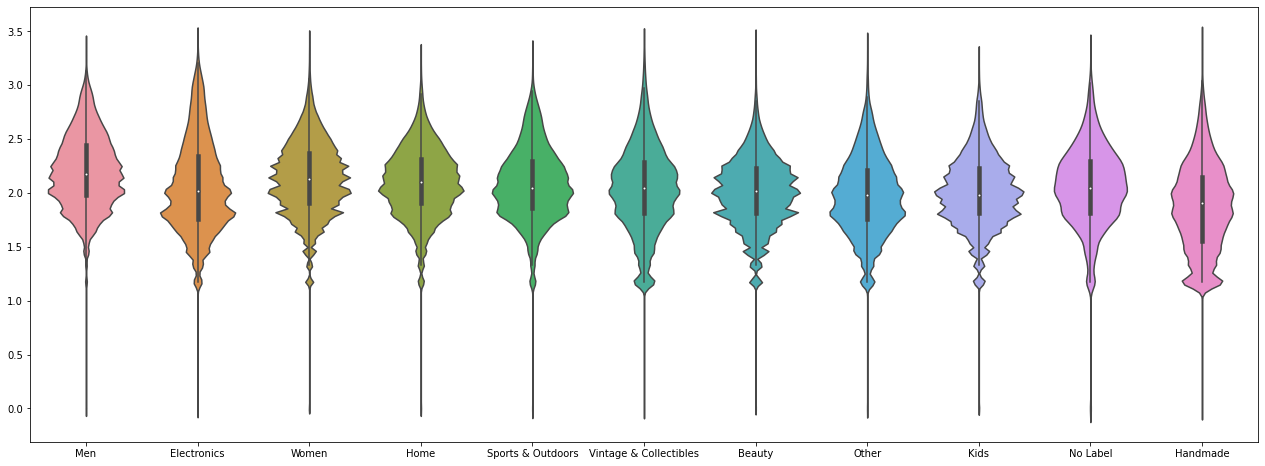

In [ ]:
plt.figure(figsize=(22,8))
ax = sns.violinplot(data=gen_cat)
ax.set_xticklabels([cat for cat in train_df['general_cat'].unique()])

From the above graph we can see that there is a little difference in the distribution of the log prices for every general category. Relying solely on the general category to make a price prediction will not be a good idea. We should use it in combination of other categories features.

In [ ]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'box_cox_price', 'general_cat',
       'subcat_1', 'subcat_2'],
      dtype='object')

In [ ]:
# Correlation
# pointbiserialr correlation is used when we want to calculate the correlation between a nominal data and continuous data.
from scipy.stats import pointbiserialr
pbc_condition = pointbiserialr(train_df['item_condition_id'], train_df['log_prices'])
pbc_shipping = pointbiserialr(train_df['shipping'], train_df['log_prices'])
print("item_condition -> log_prices correlation=", pbc_condition[0])
print("shipping -> log_prices correlation=   ", pbc_shipping[0])

item_condition -> log_prices correlation= -0.018621807176477642
shipping -> log_prices correlation=    -0.19386359714613


We can see that the item condition has a very poor correlation with the target variable. This was also evident when we saw the distribution of each category as per the prices. However, we should not discard this feature, because logically the item condition does affect the price of the product. It is just that it should not be solely used for predicting the price. It would be meaningful to use it in combination with other features, most logically of which is the <i>brand name</i> and the <i>item category</i>. This is because a worn out iPhone X would still cost a couple 100 dollars more than a totally new Micromax phone. Or a Laptop in 'fair' condition would still cost more than a new Nike T-shirt!
 Shipping does have some negative correlation with the target variable.

## **More EDA**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_descriptive_text_column(text_data):
    """
    Description:
    This function will process the text data.

    Input: original strings [in list form]
    Output: processed strings [in list form]
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    processed_text = []
    for sentance in tqdm(text_data):
        sent = decontract_text(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_text.append(sent.lower().strip())
    return np.array(processed_text)

In [ ]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'unk_brand']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'unk_brand'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='unk_brand':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('unk_brand')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separated the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then we will remove the original category_name field.

    Input: Dataframe
    Output: Dataframe
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

In [ ]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.302585,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces


In [ ]:
train_df = fill_missing_values(train_df)

In [ ]:
train_df['name'] = preprocess_descriptive_text_column(train_df['name'].values)

In [ ]:
train_df['brand_name'] = train_df['brand_name'].apply(lambda x: str(x).lower())

In [ ]:
train_df = brand_guesser(train_df)

### **Top 15 brands Wordcloud**

In [ ]:
top_brands = train_df.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

Text(0.5, 1.0, 'Top 15 expensive brands')

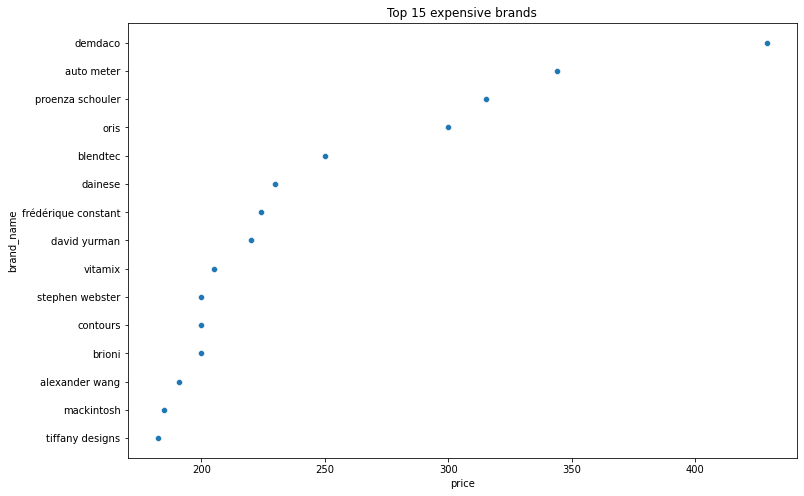

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=top_brands, x="price", y="brand_name")
plt.title("Top 15 expensive brands")

**Description**

In [ ]:
top_brands_descriptions = ' '.join(train_df.loc[train_df['brand_name'].isin(top_brands['brand_name'])]['item_description'].tolist())

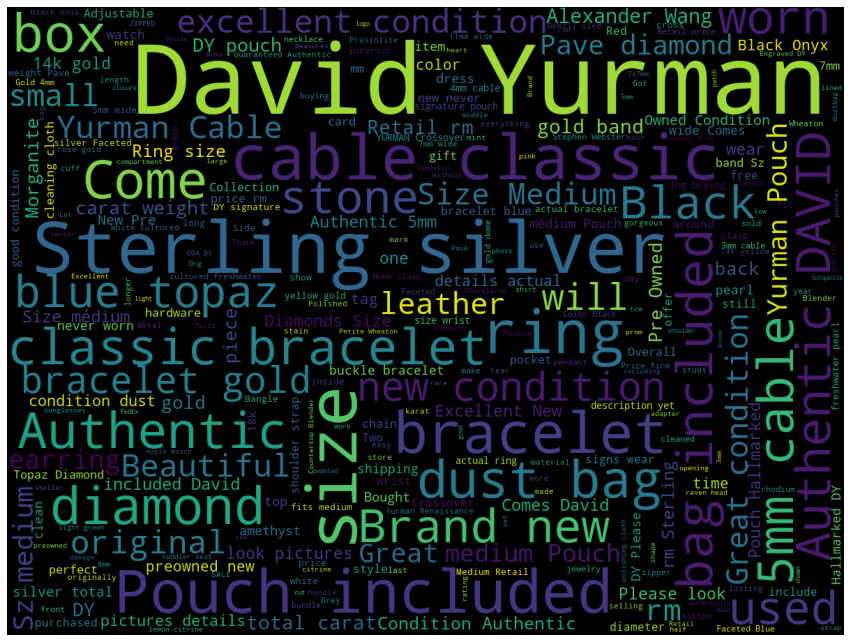

In [ ]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(top_brands_descriptions)
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Name**

In [ ]:
top_brands_name = ' '.join(train_df.loc[train_df['brand_name'].isin(top_brands['brand_name'])]['name'].tolist())

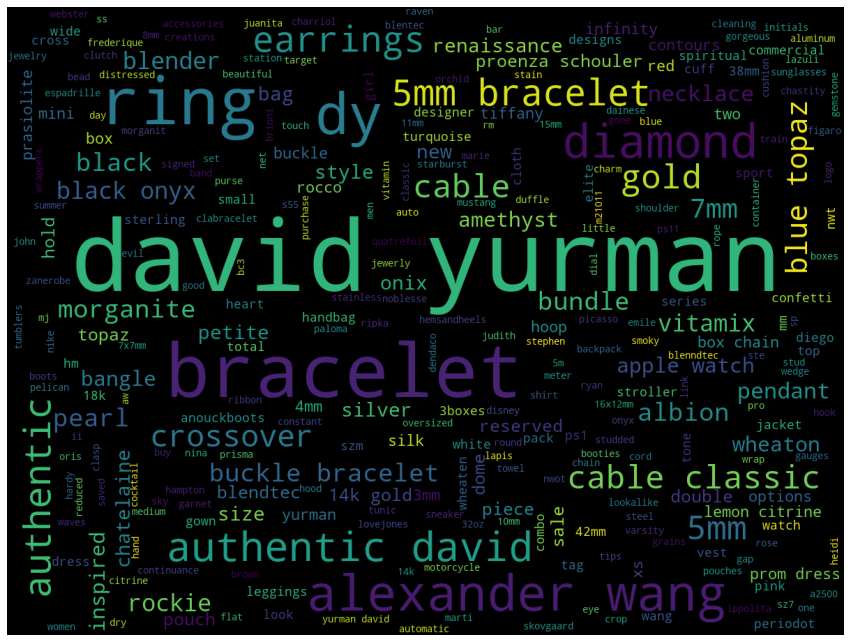

In [ ]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(top_brands_name)
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

### **Top 10 brands for each category**

In [ ]:
train_df = split_categories(train_df)

In [ ]:
# printing df side-by-side, https://stackoverflow.com/a/57832026/7697658
from IPython.core.display import display, HTML

def display_side_by_side(dfs, captions):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

unique_gen_cat = train_df['general_cat'].unique()
print("Top 10 Brands for each category\n--------------------------------\n")
df_list = []
captions_list = []
median_price_category=[]
for gc_ in unique_gen_cat:
    df_list.append(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:10])
    captions_list.append(gc_)
display_side_by_side(df_list, captions_list)

Top 10 Brands for each category
--------------------------------



,brand_name,price
0,oris,300.000000
1,bench,254.000000
2,dainese,230.000000
3,frédérique constant,224.000000
4,balenciaga,203.000000
5,christian louboutin,202.000000
6,brioni,200.000000
7,lucchese,186.000000
8,valentino,180.000000
9,thom browne,180.000000


### **Cheap and expensive brands**

In [ ]:
##print 90 to 100 percentile values with step size of 1. 
unique_gen_cat = train_df['general_cat'].unique()
cat_threshold_percetile = {}
for gc_ in unique_gen_cat: 
    print(gc_,"\n-------------")
    for i in range(90,101):
        print(i,"th percentile is",np.percentile(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, i))
    cat_threshold_percetile[gc_]=np.percentile(train_df[train_df['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)
    print()

Men 
-------------
90 th percentile is 50.0
91 th percentile is 51.0
92 th percentile is 54.0
93 th percentile is 56.930000000000064
94 th percentile is 64.75999999999931
95 th percentile is 69.95000000000005
96 th percentile is 78.96000000000004
97 th percentile is 85.0
98 th percentile is 115.80000000000018
99 th percentile is 164.45500000000004
100 th percentile is 300.0

Electronics 
-------------
90 th percentile is 61.0
91 th percentile is 64.555
92 th percentile is 66.44
93 th percentile is 69.50999999999999
94 th percentile is 75.73999999999995
95 th percentile is 82.59999999999991
96 th percentile is 87.07999999999996
97 th percentile is 100.89999999999964
98 th percentile is 128.58000000000004
99 th percentile is 136.93
100 th percentile is 352.5

Women 
-------------
90 th percentile is 44.0
91 th percentile is 46.0
92 th percentile is 49.0
93 th percentile is 51.0
94 th percentile is 58.48000000000002
95 th percentile is 65.15000000000009
96 th percentile is 75.319999999999

In [ ]:
expensive_brands = []
unique_gen_cat = train_df['general_cat'].unique()
for gc_ in unique_gen_cat:
    temp_df = train_df[train_df['general_cat']==gc_][['brand_name','price']].values
    for row in temp_df:
        if row[1]>=cat_threshold_percetile[gc_]:
            expensive_brands.append(row[0])
expensive_brands = set(expensive_brands)

In [ ]:
len(expensive_brands)

1593

### **Brand & Condition -> Price**

In [ ]:
def get_interactions(col1, col2, top_brand=None):
    interaction_df = pd.DataFrame()
    if top_brand is not None:
        unique_values_col1 = top_brand['brand_name'].unique()
    else:
        unique_values_col1 = train_df[col1].unique()
        
    for uv in unique_values_col1:
        interaction_df = pd.concat([interaction_df, train_df[train_df[col1]==uv].groupby(col2).median()['price'].rename(uv)], axis=1)
    return interaction_df

def visualize_interactions(interaction_df, title, annot_=True):
    plt.figure(figsize=(12,7))
    ax = sns.heatmap(
        interaction_df,
        cmap="Blues",
        annot=annot_,
        cbar_kws={'label': 'Prices', 'orientation': 'vertical'},
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.title(title)

In [ ]:
# def get_interactions(col1, col2):
#     interaction_df = pd.DataFrame()
#     unique_values_col1 = train_df[col1].unique()
#     for uv in unique_values_col1:
#         interaction_df[uv]=train_df[train_df[col1]==uv].groupby(col2).median()['price']
#     return interaction_df

# def visualize_interactions(interaction_df, title):
#     plt.figure(figsize=(12,7))
#     ax = sns.heatmap(
#         interaction_df,
#         cmap="Blues",
#         annot=True,
#         cbar_kws={'label': 'Prices', 'orientation': 'vertical'}
#     )
#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     )
#     plt.title(title)

In [ ]:
top_brands = train_df.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

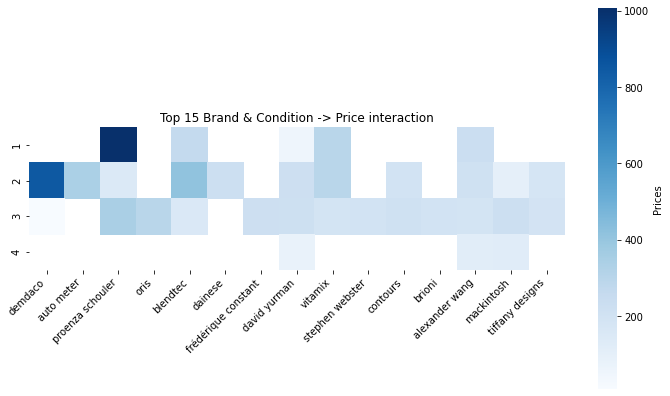

In [ ]:
interaction_df = get_interactions('brand_name', 'item_condition_id', top_brand=top_brands)
visualize_interactions(interaction_df, 'Top 15 Brand & Condition -> Price interaction', annot_=False)

### **Brand & Condition -> Price [ML model]**

In [ ]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.302585,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces


In [ ]:
def vectorize_data(col_data, count_vectorizer=None):
    """
    Description:
    This funciton will count vectorize the input column data.

    Input: dataframe column
    Output: one-hot encoded values and the fitted vectorizer
    """
    if count_vectorizer==None:
        count_vectorizer = CountVectorizer()
        count_vectorizer.fit(col_data)
    ohe_data = count_vectorizer.transform(col_data)
    return ohe_data, count_vectorizer

In [ ]:
# create simple ml model to predict the bin/class given the data
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from scipy.sparse import hstack, coo_matrix
from sklearn import preprocessing

brand_name_encoded, _ = vectorize_data(train_df['brand_name'].values.astype('U'))
x_temp = hstack((brand_name_encoded, train_df['item_condition_id'].values.reshape(-1,1))).tocsr()

In [ ]:
# bin the target variable
bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
labels = [1,2,3,4,5,6,7]
y_train_binned = pd.cut(train_df['log_prices'], bins=bins, labels=labels)
y_binned_array = np.array(y_train_binned.tolist())

y_binned_array[np.isneginf(y_binned_array)] = 0
y_binned_array[np.isnan(y_binned_array)] = 0

# Using binned classification
#-----------------------------
lr = SGDClassifier(random_state=15)
lr.fit(x_temp, y_binned_array)
y_binned_predicted = lr.predict(x_temp)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_binned_array, y_binned_predicted))

0.5442967619651475


In [ ]:
# Random model
random_preds = np.random.choice(labels, len(y_binned_array))
print(accuracy_score(y_binned_array, random_preds))

0.1432714910609193


### **Brand & Category -> Price**

In [ ]:
top_brands = train_df.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

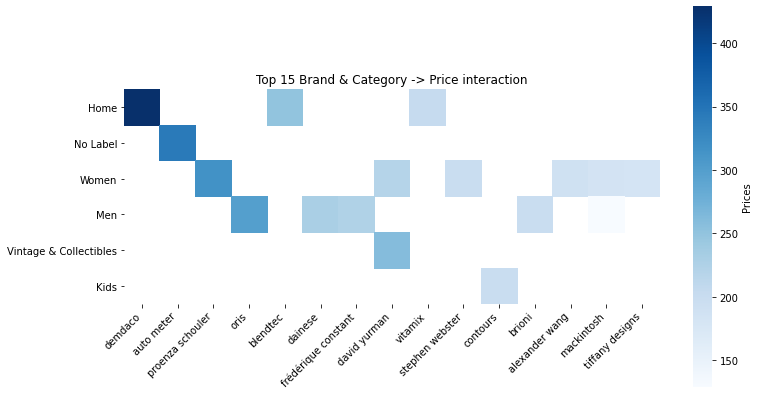

In [ ]:
interaction_df = get_interactions('brand_name', 'general_cat', top_brand=top_brands)
visualize_interactions(interaction_df, 'Top 15 Brand & Category -> Price interaction', annot_=False)

### **Categroy & Condition -> Price**

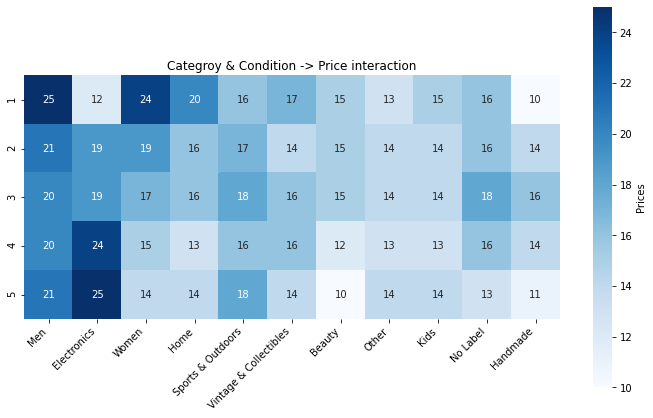

In [ ]:
interaction_df = get_interactions('general_cat', 'item_condition_id')
visualize_interactions(interaction_df, 'Categroy & Condition -> Price interaction')

### **Category -> price**

In [ ]:
gen_cat_median = train_df.groupby('general_cat').median().sort_values("price", ascending=False)['price'].reset_index()

Text(0.5, 1.0, 'Median prices for each general category')

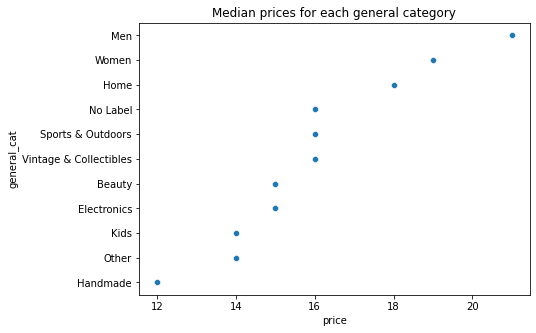

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=gen_cat_median, x="price", y="general_cat")
plt.title("Median prices for each general category")

In [ ]:
sub_cat_1_cat_median = train_df.groupby('subcat_1').median().sort_values("price", ascending=False)['price'].reset_index()

Text(0.5, 1.0, 'Median prices for each subcat 1 category')

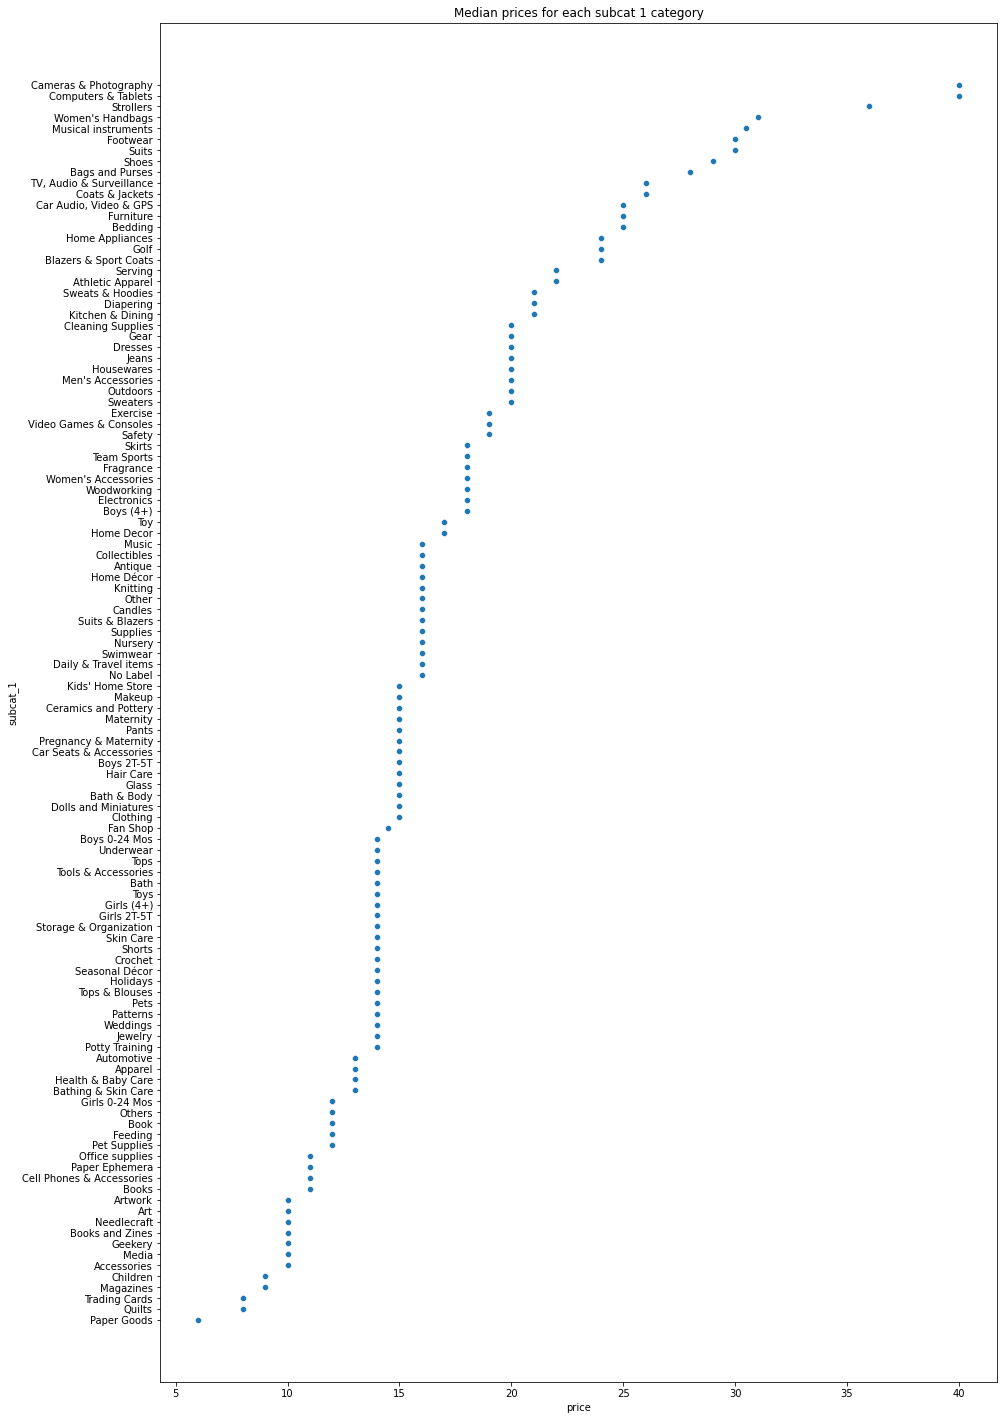

In [ ]:
plt.figure(figsize=(15,25))
sns.scatterplot(data=sub_cat_1_cat_median, x="price", y="subcat_1")
plt.title("Median prices for each subcat 1 category")

# **Key take-aways from EDA**

<ul>
<li>42.68% of the data has null brand name. We saw that although the brand name field is misisng, the seller often mentions the brand name in the item name field. We filled the missing brand name by applying a heuristic algorithm by guessing the brand name from the item name field. We could fill around 1,35,000 brands with this approach.</li>
<li>The prices are highly skewed to the right. Hence, we applied a log transformation on the prices to make them somewhat normally distributed.</li>
<li>The correlation of shipping and price shows that, if the shipping is paid by the seller, then the price of the product tends to be a little less as compared to otherwise.</li>
<li>There are 5 levels of item condition; 1 to 5. 1 being new and 5 being poor. 43.21% of the products are in 'new' condition (condition 1), followed by 29.15% of 'good' condition (condition 3)</li>
<li>The effect of item condition on price (seen from the violin plot) shows that, the prices are highest for 'poor' conditioned products, followed by 'new' condition products. This might be due to the fact that those products in poor condition are of such category where the prices are usualyy higher, for eg: electronic category like laptop, sports category like hoverboard, etc. So their native prices are itself very high.</li>
<li>The word cloud of the item name tells us that majority of the sellers write the name of the brand in it. This was the motivation that drove me in building a heuristic algorithm to guess the brand name from the item name.</li>
<li>The word count of the item descriptions is like a log normal distribution.</li>
<li>After dividing the category into three parts, the Women category leads the main category with being 44.81%, followed by Beauty category with being 14.02%. Sports category has the least count.</li>
<li>After observing the interaction of main category with the prices, it is seen that the Men category has the highest priced products.</li>
<li>After observing the subcategory, it is seen that most of the products are apperals</li>
<li>The brand 'demdaco' is the costliest brand, followed by 'auto meter' and 'proenza schouler'</li>
<li>For each main category, we took the median prices of each brand, and found top 10 brands for each category.</li>
<li>A new feature was enginerred which tells us whether the brand is expensive or not. The expensiveness of the brand was judged from the price of the products. For each category, I saw the distribution of the (median)prices of each brand. In that the 95th percentile price seemed to be a good threshold for the expensiveness of the product. If the price of the product is above that threshold, then the brand is expensive.</li>
<li>The interaction of the top 15 brands(as per median price) and item condition showed us that, these expensive brands don't have any items in 'poor' condition. Most of them are sold with condition 2 and 3</li>
<li>In order to see further interaction between brand and item condition, I created a very basic SGD classifier with only the brand name and item condition. I binned the prices and made it a categorical variable. Then I trained and evaluated the model's accuracy. It gave me around 54%, which is more than a random model with 14% accuracy. This means that these two features would add some meaning to the final model.</li>
<li>The interaction between the category and item condition showed us that, Men, Women and Home category(each) products are sold the costliest in the condition 1. Electronics are sold highest with condition 4 and 5.</li>
<li>From the subcategory and price interaction, it is seen that Camera & Photography is the costliest subcategory, followed by Computers & Tablets. The cheapest ones are Paper Goods and Quilts</li>
</ul>

# **Feature Engineering (the 'get-go' version)**

* Handle missing values in brand name<br>
* Sentiment scores features<br>
* Add a binary feature for the missing values in brand name<br>
* Item description len<br>
* Item name len<br>
* Data pre-processing

**Adding log price column**

Fitted Lambda = -0.2435088863869136


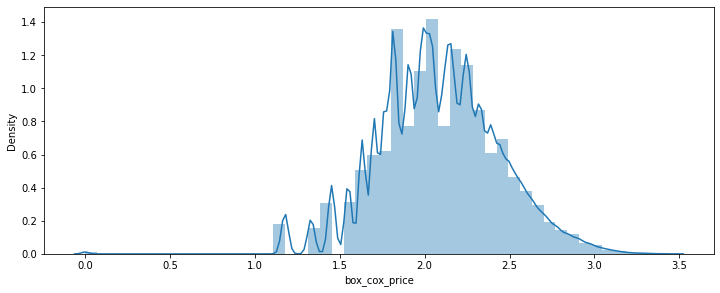

In [ ]:
from scipy import stats

train_df['log_prices'] = np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_prices'])

**Train Test Split**

In [ ]:
X = train_df.drop(['train_id','log_prices','price'], axis=1)
y = train_df['log_prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
del X, y

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1186028, 9)
(1186028,)
(296507, 9)
(296507,)


### **Filling missing values**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

In [ ]:
X_train = fill_missing_values(X_train)
X_train.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
1416089,LuLaRoe kids L/XL leggings,3,Kids/Boys (4+)/Bottoms,unk_brand,1,Worn once. Still in great condition,Kids,Boys (4+),Bottoms
1423955,Bundle 5 Display mannequins,1,Other/Other/Other,unk_brand,0,Brand new,Other,Other,Other
403867,LIVING PROOF PERFECT HAIR DAY DRY SHAMPO,1,Beauty/Hair Care/Styling Products,unk_brand,0,This listing is for 3 full size bottles of liv...,Beauty,Hair Care,Styling Products
701974,Palazzo pants,2,Women/Pants/Casual Pants,unk_brand,0,Like new adorable black and white palazzo pant...,Women,Pants,Casual Pants
1124330,RESERVED FOR Ms Jas PINK BOYSHORTS LARGE,1,Women/Underwear/Panties,PINK,1,NEW WITH TAGS MORNING SKY SHEER SEAFOAM OLIVE ...,Women,Underwear,Panties


### **Text Pre-processing**

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_descriptive_text_column(text_data):
    """
    Description:
    This function will process the text data.

    Input: original strings [in list form]
    Output: processed strings [in list form]
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    processed_text = []
    for sentance in tqdm(text_data):
        sent = decontract_text(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_text.append(sent.lower().strip())
    return np.array(processed_text)

In [ ]:
X_train['item_description'] = preprocess_descriptive_text_column(X_train['item_description'].values)

In [ ]:
X_train['name'] = preprocess_descriptive_text_column(X_train['name'].values)

In [ ]:
X_train['brand_name'] = X_train['brand_name'].apply(lambda x: str(x).lower())

### **Make Shipping data sparse**

In [ ]:
def get_shipping_feature(df):
    """
    Description:
    This funciton will get a sparse feature of the shipping type.

    Input: Dataframe
    Output: Sparse shipping data
    """
    sparse_shipping = scipy.sparse.csr_matrix(df['shipping'].values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

In [ ]:
sparse_shipping = get_shipping_feature(X_train)

### **Fill Missing Brand Names**

In [ ]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'unk_brand']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'unk_brand'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='unk_brand':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('unk_brand')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [ ]:
train_df[['brand_name','name','category_name']].values[1][1]

'Razer BlackWidow Chroma Keyboard'

In [ ]:
before_filling = X_train['brand_name'].value_counts()['unk_brand']
before_filling

506058

In [ ]:
X_train = brand_guesser(X_train)

In [ ]:
after_filling = X_train['brand_name'].value_counts()['unk_brand']
after_filling

370784

In [ ]:
brands_filled = before_filling - after_filling
brands_filled

135274

### **Add a binary feature for the missing values in brand name**

In [ ]:
def get_binary_missing_brand_feature(df):
    """
    Description:
    This funciton will get a binary feature which will tell us if the brand name of the product is missing (1) or not (0).

    Input: Dataframe
    Output: binary values for all each row/product
    """
    binary_missing_brand = df['brand_name'].apply(lambda x: 1 if x=='unk_brand' else 0)
    binary_missing_brand = scipy.sparse.csr_matrix(binary_missing_brand)
    binary_missing_brand = binary_missing_brand.reshape(-1,1) # Now the shape will be (1111901, 1)
    return binary_missing_brand

In [ ]:
binary_missing_brand = get_binary_missing_brand_feature(X_train)

### **Split Categories**

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separated the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then we will remove the original category_name field.

    Input: Dataframe
    Output: Dataframe
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

In [ ]:
X_train = split_categories(X_train)
X_train.head()

,name,item_condition_id,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
1416089,lularoe kids l xl leggings,3,unk_brand,1,worn still great condition,Kids,Boys (4+),Bottoms
1423955,bundle 5 display mannequins,1,unk_brand,0,brand new,Other,Other,Other
403867,living proof perfect hair day dry shampo,1,unk_brand,0,listing 3 full size bottles living proof perfe...,Beauty,Hair Care,Styling Products
701974,palazzo pants,2,unk_brand,0,like new adorable black white palazzo pants no...,Women,Pants,Casual Pants
1124330,reserved ms jas pink boyshorts large,1,pink,1,new tags morning sky sheer seafoam olive green,Women,Underwear,Panties


### **Adding Sentiment Scores**

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def get_sentiments_feature(df):
    """
    Description:
    This function will calculate the sentiment scores of each item description.
    It will calculate four scores for each sentence; compund, negetive, neutral, positive

    Input: Dataframe
    Output: sentiment scores for all the product's description
    """
    sentiments = []
    sid = SentimentIntensityAnalyzer()
    for desc in tqdm(df['item_description'].apply(str).values):
        ss = sid.polarity_scores(desc)
        sentiments.append([ss['neg'],ss['neu'],ss['pos']])
    return np.array(sentiments)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sentiments_feature = get_sentiments_feature(X_train)

In [ ]:
sentiments_price_data = np.append(sentiments_feature, np.array(y_train).reshape(-1,1), axis=1)
sentiments_price_data = pd.DataFrame(sentiments_price_data, columns=['neg','neu','pos','box_cox_price'])
sentiments_price_data.head()

,neg,neu,pos,box_cox_price
0,0.265,0.241,0.494,2.016025
1,0.000,1.000,0.000,2.481402
2,0.082,0.750,0.168,2.390648
3,0.073,0.672,0.255,2.126592
4,0.000,1.000,0.000,2.327014


                    neg       neu       pos  box_cox_price
neg            1.000000 -0.471038 -0.249073      -0.011368
neu           -0.471038  1.000000 -0.728826       0.022614
pos           -0.249073 -0.728826  1.000000      -0.015179
box_cox_price -0.011368  0.022614 -0.015179       1.000000


[Text(0.5, 0, 'neg'),
 Text(1.5, 0, 'neu'),
 Text(2.5, 0, 'pos'),
 Text(3.5, 0, 'box_cox_price')]

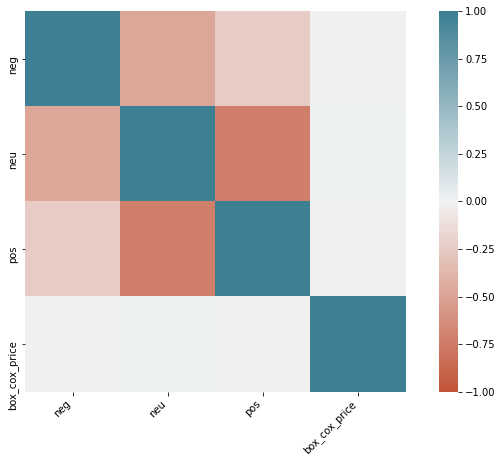

In [ ]:
sentiment_correlations = sentiments_price_data.corr()
print(sentiment_correlations)
plt.figure(figsize=(12,7))
ax = sns.heatmap(
    sentiment_correlations, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

### **Adding Item Description len and Item Name len**

In [ ]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the item name and standardize it.

    Input: Series, fitted scaler[during inference]
    Output: standardized name length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

In [ ]:
name_len, scaler_name_len =  get_len_feature(X_train['name'])

In [ ]:
desc_len, scaler_desc_len =  get_len_feature(X_train['item_description'])

In [ ]:
lens_price_data = np.column_stack((desc_len, name_len, np.array(y_train).reshape(-1,1)))
lens_price_data = pd.DataFrame(lens_price_data, columns=['desc_len','name_len','box_cox_price'])
lens_price_data.head()

,desc_len,name_len,box_cox_price
0,-0.689477,0.499096,2.016025
1,-0.785194,-0.130965,2.481402
2,1.512006,1.759218,2.390648
3,2.708465,-1.391087,2.126592
4,-0.498044,1.129157,2.327014


               desc_len  name_len  box_cox_price
desc_len       1.000000  0.244451       0.030034
name_len       0.244451  1.000000       0.051775
box_cox_price  0.030034  0.051775       1.000000


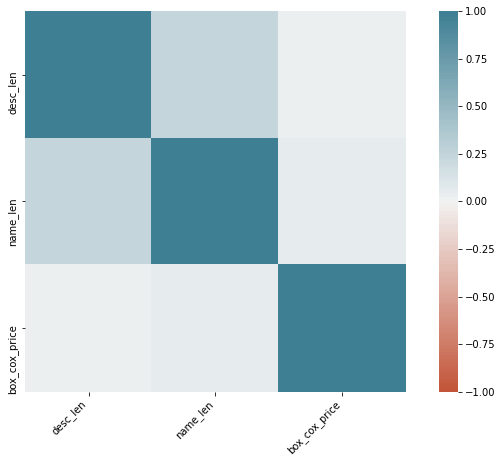

In [ ]:
correlations = lens_price_data.corr()
print(correlations)
plt.figure(figsize=(12,7))
ax = sns.heatmap(
    correlations, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### **Cheap and expensive brands**

In [ ]:
X_temp, _, _, _ = train_test_split(train_df, train_df['price'], test_size=0.20, random_state=42)
X_temp = fill_missing_values(X_temp)
X_temp['name'] = preprocess_descriptive_text_column(X_temp['name'].values)
X_temp['brand_name'] = X_temp['brand_name'].apply(lambda x: str(x).lower())
X_temp = brand_guesser(X_temp)
X_temp = split_categories(X_temp)

In [ ]:
X_temp.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,box_cox_price,general_cat,subcat_1,subcat_2
1416089,1416089,lularoe kids l xl leggings,3,unk_brand,15.0,1,Worn once. Still in great condition,2.016025,Kids,Boys (4+),Bottoms
1423955,1423955,bundle 5 display mannequins,1,unk_brand,44.0,0,Brand new,2.481402,Other,Other,Other
403867,403867,living proof perfect hair day dry shampo,1,unk_brand,35.0,0,This listing is for 3 full size bottles of liv...,2.390648,Beauty,Hair Care,Styling Products
701974,701974,palazzo pants,2,unk_brand,19.0,0,Like new adorable black and white palazzo pant...,2.126592,Women,Pants,Casual Pants
1124330,1124330,reserved ms jas pink boyshorts large,1,pink,30.0,1,NEW WITH TAGS MORNING SKY SHEER SEAFOAM OLIVE ...,2.327014,Women,Underwear,Panties


In [ ]:
unique_gen_cat = X_train['general_cat'].unique()
cat_threshold_percetile = {}
for gc_ in unique_gen_cat: 
    cat_threshold_percetile[gc_] = \
            np.percentile(X_train[X_train['general_cat']==gc_].groupby('brand_name').median().\
                          sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)

In [ ]:
##print 90 to 100 percentile values with step size of 1. 
unique_gen_cat = X_temp['general_cat'].unique()
cat_threshold_percetile = {}
for gc_ in unique_gen_cat: 
    print(gc_,"\n-------------")
    for i in range(90,101):
        print(i,"th percentile is",np.percentile(X_temp[X_temp['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, i))
    cat_threshold_percetile[gc_]=np.percentile(X_temp[X_temp['general_cat']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)
    print()

Kids 
-------------
90 th percentile is 32.0
91 th percentile is 34.0
92 th percentile is 35.0
93 th percentile is 36.435
94 th percentile is 39.919999999999845
95 th percentile is 45.0
96 th percentile is 49.31999999999999
97 th percentile is 60.11500000000001
98 th percentile is 72.40999999999997
99 th percentile is 90.1249999999996
100 th percentile is 207.5

Other 
-------------
90 th percentile is 40.0
91 th percentile is 41.0
92 th percentile is 44.81999999999999
93 th percentile is 50.0
94 th percentile is 54.65999999999997
95 th percentile is 61.049999999999955
96 th percentile is 65.0
97 th percentile is 74.14999999999992
98 th percentile is 87.97999999999973
99 th percentile is 119.61000000000001
100 th percentile is 184.0

Beauty 
-------------
90 th percentile is 26.099999999999994
91 th percentile is 27.58000000000004
92 th percentile is 29.0
93 th percentile is 30.340000000000032
94 th percentile is 32.0
95 th percentile is 36.0
96 th percentile is 37.73999999999998
97 th

In [ ]:
expensive_brands = []
unique_gen_cat = X_train['general_cat'].unique()
for gc_ in unique_gen_cat:
    temp_df = X_train[X_train['general_cat']==gc_][['brand_name','price']].values
    for row in temp_df:
        if row[1]>=cat_threshold_percetile[gc_]:
            expensive_brands.append(row[0])
expensive_brands = list(set(expensive_brands))
try:
    expensive_brands.remove('unk_brand')
except:
    pass

In [ ]:
print(expensive_brands)

['justin boots', 'thierry mugler', 'popatu', "kiehl's", 'silpada', 'rand mcnally', 'jordans', 'cambridge satchel', 'h&m', 'sanctuary', 'pfaltzgraff', 'playhut', 'crayola', 'milani', 'creative designs', 'lite brix', 'infantino', 'roller derby', 'makeup geek', 'red wing shoes', 'homedics', 'apple bottoms', 'dressbarn', 'dji', 'andrew marc', 'dooney & bourke', 'corral', 'abu garcia', 'josie natori', 'uppababy', 'halo', 'jack rogers', 'lush', 'ben nye', 'hohner kids', 'magic bullet', 'zales', 'nvidia', 'urban decay', 'pur', 'asus', 'fjallraven', 'demdaco', 'lansinoh', 'good technology', 'contours', 'rag & bone', 'hermès', 'tonka', 'american fighter', 'cartier', 'beauticontrol', 'shinola', 'j kara', 'pur minerals', 'hasbro', 'wildfox', 'office depot', 'donnybrook', 'ultimate ears', 'zella', 'missoni', 'plantronics', 'tahari', 'ping', 'coulbourne', 'nest', 'senegence', 'nixon', "arc'teryx", 'tokidoki', 'giorgio armani', 'juicy couture', 'all saints', 'irobot', 'the instrument store', 'blondi

In [ ]:
len(expensive_brands)

1458

In [ ]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'wb') as f:
    pickle.dump(expensive_brands, f)

In [ ]:
X_train.head()

,name,item_condition_id,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,is_expensive
1416089,lularoe kids l xl leggings,3,unk_brand,1,worn still great condition,Kids,Boys (4+),Bottoms,1
1423955,bundle 5 display mannequins,1,unk_brand,0,brand new,Other,Other,Other,1
403867,living proof perfect hair day dry shampo,1,unk_brand,0,listing 3 full size bottles living proof perfe...,Beauty,Hair Care,Styling Products,1
701974,palazzo pants,2,unk_brand,0,like new adorable black white palazzo pants no...,Women,Pants,Casual Pants,1
1124330,reserved ms jas pink boyshorts large,1,pink,1,new tags morning sky sheer seafoam olive green,Women,Underwear,Panties,1


In [ ]:
X_train['is_expensive'] = X_train['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)

In [ ]:
X_train.head()

,name,item_condition_id,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,is_expensive
1416089,lularoe kids l xl leggings,3,unk_brand,1,worn still great condition,Kids,Boys (4+),Bottoms,0
1423955,bundle 5 display mannequins,1,unk_brand,0,brand new,Other,Other,Other,0
403867,living proof perfect hair day dry shampo,1,unk_brand,0,listing 3 full size bottles living proof perfe...,Beauty,Hair Care,Styling Products,0
701974,palazzo pants,2,unk_brand,0,like new adorable black white palazzo pants no...,Women,Pants,Casual Pants,0
1124330,reserved ms jas pink boyshorts large,1,pink,1,new tags morning sky sheer seafoam olive green,Women,Underwear,Panties,1


In [ ]:
X_train['is_expensive'].sum()

771004

### **Make is_expensive data (sparse)**

In [ ]:
def get_is_expensive_feature(df, expensive_brands):
    """
    Description:
    This funciton will get a sparse feature of the is_expensive type.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    df['is_expensive'] = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    sparse_shipping = scipy.sparse.csr_matrix(df['is_expensive'].values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'rb') as f:
    expensive_brands = pickle.load(f)

sparse_is_expensive = get_is_expensive_feature(X_train, expensive_brands)

### **Vectorizing data**

In [ ]:
def vectorize_data(col_data, count_vectorizer=None):
    """
    Description:
    This funciton will count vectorize the input column data.

    Input: dataframe column
    Output: one-hot encoded values and the fitted vectorizer
    """
    if count_vectorizer==None:
        count_vectorizer = CountVectorizer()
        count_vectorizer.fit(col_data)
    ohe_data = count_vectorizer.transform(col_data)
    return ohe_data, count_vectorizer

In [ ]:
general_cat_ohe, general_cat_vectorizer = vectorize_data(X_train['general_cat'].values.astype('U'))
subcat_1_ohe, subcat_1_vectorizer = vectorize_data(X_train['subcat_1'].values.astype('U'))
subcat_2_ohe, gsubcat_2_vectorizer = vectorize_data(X_train['subcat_2'].values.astype('U'))
brand_name_ohe, brand_name_vectorizer = vectorize_data(X_train['brand_name'].values.astype('U'))
item_name_ohe, item_name_vectorizer = vectorize_data(X_train['name'].values.astype('U'))

In [ ]:
import pickle
def glove_vectorize_text_data(col):
    """
    Description:
    This funciton will glove vectorize (100 dimensions) the input text data

    Input: dataframe column
    Output: glove vectorized text data
    """
    glove_path = '/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/glove.6B.100d.txt'
    embeddings_index = dict()
    with open(glove_path) as f:
        for line in f:
            w_coef = line.split()
            word = w_coef[0]
            coefs = np.asarray(w_coef[1:], dtype='float32')
            embeddings_index[word]=coefs
    print(len(embeddings_index))

    # Avg Word2Vec
    # compute Avg word2vec for each description.
    avg_w2v_vectors = [] # the tfidf-w2v for each sentence is stored in this list
    for sentence in tqdm(col): # for each sentence
        vector = np.zeros(100) # as word vectors are of zero length
        word_count=0 # num of words with a valid vector in the sentence
        for word in str(sentence).split(): # for each word in a sentence
            if word in embeddings_index.keys():
                vec = embeddings_index[word] # getting the vector for each word
                vector += vec
                word_count += 1
        if word_count != 0:
            vector /= word_count
        avg_w2v_vectors.append(vector)

    return np.array(avg_w2v_vectors)

In [ ]:
avg_w2v_vectors_train = glove_vectorize_text_data(X_train['item_description'].values)
avg_w2v_vectors_train.shape

400000


(1186028, 100)

### **Final Training Data**

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((general_cat_ohe, subcat_1_ohe, subcat_2_ohe, brand_name_ohe, item_name_ohe, avg_w2v_vectors_train, 
               binary_missing_brand, sentiments_feature, desc_len, name_len, X_train['item_condition_id'].values.reshape(-1,1), sparse_is_expensive, sparse_shipping)).tocsr()

print("="*50)
print("Final Data matrix:")
print(X_tr.shape, y_train.shape)
print("="*50)

X_tr_size = X_tr.data.nbytes + X_tr.indptr.nbytes + X_tr.indices.nbytes
print("Size of X_tr in memory =", int(X_tr_size/1024/1024),"MB")

Final Data matrix:
(1186028, 98635) (1186028,)
Size of X_tr in memory = 1575 MB
